In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import torch

import os
from dotenv import load_dotenv

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

load_dotenv()

True

# Работа с признаками

In [8]:
conn = psycopg2.connect(os.environ["POSTGRES_CONN"])

## Таблица с постами

In [17]:
# Таблица с постами
post_text_df = pd.read_sql("SELECT * FROM post_text_df", conn)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [8]:
post_text_df['total_len'] = post_text_df['text'].apply(len)
post_text_df.head()

,post_id,text,topic,total_len
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701
2,3,Asian quake hits European shares\n\nShares in ...,business,3408
3,4,India power shares jump on debut\n\nShares in ...,business,1026
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889


In [18]:
# Приведение текста к одному виду

import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to /Users/dmitry/nltk_data...


TfidfVectorizer(preprocessor=<function preprocessing at 0x1427922a0>,
                stop_words='english')

In [21]:
tfidf_data = (
    tfidf
    .fit_transform(post_text_df['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=post_text_df.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Кластеризация текстов

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_decomp)

post_text_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster
0,0.493441,0.473548,0.434876,0.449122,0.327339,0.495972,0.441822,0.454048,0.519623,0.466507
1,0.364252,0.336503,0.278597,0.307292,0.153631,0.368690,0.297829,0.291786,0.251996,0.331836
2,0.388896,0.359959,0.306739,0.333451,0.174627,0.383497,0.330572,0.340945,0.462773,0.366570
3,0.324394,0.315906,0.250935,0.272601,0.111932,0.344391,0.291741,0.280724,0.409760,0.323763
4,0.287583,0.256753,0.165441,0.197349,0.124815,0.288968,0.226114,0.234444,0.372978,0.304076


In [24]:
post_text_df = pd.concat((post_text_df,dists_df), axis=1)

post_text_df.head()

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,4,0.493441,0.473548,0.434876,0.449122,0.327339,0.495972,0.441822,0.454048,0.519623,0.466507
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,4,0.364252,0.336503,0.278597,0.307292,0.153631,0.368690,0.297829,0.291786,0.251996,0.331836
2,3,Asian quake hits European shares\n\nShares in ...,business,4,0.388896,0.359959,0.306739,0.333451,0.174627,0.383497,0.330572,0.340945,0.462773,0.366570
3,4,India power shares jump on debut\n\nShares in ...,business,4,0.324394,0.315906,0.250935,0.272601,0.111932,0.344391,0.291741,0.280724,0.409760,0.323763
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,4,0.287583,0.256753,0.165441,0.197349,0.124815,0.288968,0.226114,0.234444,0.372978,0.304076


In [26]:
# Загружаем признаки в БД

from sqlalchemy import create_engine

engine = create_engine(
    os.environ["POSTGRES_CONN"]
)


post_text_df.to_sql(
    'd_trubitsin_post_feachures_base', 
    con=engine, if_exists='replace'
) 

23

In [27]:
# Почистим переменные

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df
del engine

import gc

gc.collect()

1535

###  Эмбеддинг для текста 

(для модели с использованием DL)

In [12]:
vector = torch.load('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/df_vector')
vector

array([[-0.04026394, -0.27968097, -0.02639238, ...,  0.257868  ,
         0.18739226,  0.31604615],
       [-0.10243215, -0.29358044,  0.02447986, ...,  0.19320787,
         0.10278795,  0.06712697],
       [-0.17103201, -0.196974  ,  0.11955357, ...,  0.11110002,
         0.16093004,  0.06588535],
       ...,
       [-0.23448637, -0.46378005,  0.46819142, ...,  0.14383662,
         0.31123495, -0.15421167],
       [-0.03112065, -0.23907664,  0.12080344, ...,  0.23640299,
         0.34705564,  0.07306456],
       [-0.55892557, -0.23251152,  0.05662002, ...,  0.05255096,
         0.51426667,  0.06540442]], dtype=float32)

In [9]:
# Создание экземпляра модели k ближайших соседей
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Обучение модели на эмбеддингах
knn.fit(vector)

# Получение расстояний и индексов k ближайших соседей для каждого эмбеддинга
distances, indices = knn.kneighbors(vector)

# Преобразование расстояний и индексов в числовые признаки
# Например, можно использовать среднее расстояние до k ближайших соседей
vec_to_num = distances.mean(axis=1)
vec_to_num

array([0.08227593, 0.11509974, 0.06522653, ..., 0.11990206, 0.10609498,
       0.12071379], dtype=float32)

In [11]:
post_text_df['vector_knn'] = vec_to_num
post_text_df.head()

,post_id,text,topic,total_len,vector_knn
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967,0.082276
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701,0.115100
2,3,Asian quake hits European shares\n\nShares in ...,business,3408,0.065227
3,4,India power shares jump on debut\n\nShares in ...,business,1026,0.166756
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889,0.128059
...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,803,0.118923
7019,7316,I give this movie 2 stars purely because of it...,movie,800,0.102609
7020,7317,I cant believe this film was allowed to be mad...,movie,636,0.119902
7021,7318,The version I saw of this film was the Blockbu...,movie,728,0.106095


In [10]:
# Понижение размерности эмбеддинга для текста
pca = PCA(n_components=40)
vector_reduced = pca.fit_transform(vector)
vector_reduced

array([[-0.6042926 , -1.7302293 , -0.2656291 , ..., -0.09555924,
         0.08054186,  0.08684012],
       [-0.37933505, -1.6182517 , -0.18222351, ...,  0.35344905,
        -0.10349544,  0.1552207 ],
       [-0.57943225, -1.3125701 , -0.5366196 , ...,  0.02226187,
        -0.2557233 ,  0.26743233],
       ...,
       [-0.3394548 ,  1.7820189 , -0.08271557, ...,  0.0446398 ,
        -0.10677332,  0.3640736 ],
       [-0.85119724,  1.3939445 ,  0.2535691 , ..., -0.14826623,
        -0.3795626 , -0.34804788],
       [-0.59959245,  1.1673808 ,  0.4794963 , ..., -0.35850045,
         0.28456897, -0.04457804]], dtype=float32)

In [12]:
post_text_df = pd.concat([post_text_df, pd.DataFrame(vector_reduced)], axis=1)
post_text_df.head()


,post_id,text,topic,total_len,vector_knn,0,1,2,3,4,...,30,31,32,33,34,35,36,37,38,39
0,1,UK economy facing major risks\n\nThe UK manufa...,business,1967,0.082276,-0.604293,-1.730229,-0.265629,-0.287930,0.902613,...,0.013911,-0.252469,0.059033,0.209930,0.225182,-0.543558,-0.145053,-0.095559,0.080542,0.086840
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2701,0.115100,-0.379335,-1.618252,-0.182224,0.393784,0.074997,...,0.181107,-0.186352,0.142517,0.010612,-0.416863,-0.092074,-0.198007,0.353449,-0.103495,0.155221
2,3,Asian quake hits European shares\n\nShares in ...,business,3408,0.065227,-0.579432,-1.312570,-0.536620,-0.314556,0.692388,...,0.123431,-0.224471,-0.100773,-0.157203,-0.100837,0.494602,-0.045970,0.022262,-0.255723,0.267432
3,4,India power shares jump on debut\n\nShares in ...,business,1026,0.166756,-0.001005,-1.071291,-0.340120,-0.310131,0.935006,...,-0.119648,0.206233,-0.000893,-0.041723,-0.247718,0.399846,0.202233,0.106277,0.394018,-0.230528
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,889,0.128059,0.009501,-0.748033,0.456167,-0.182601,0.857853,...,0.259831,0.160582,0.282803,0.008371,0.308162,-0.481156,-0.394653,-0.034847,0.389736,-0.022782


## Таблица с действиями пользователей

In [64]:
# Выделение признаков из времени
# Получение данных по каждому пользователю
# Удаление действий "like" из-за избыточности
# Объединение с таблицей с пользователями

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(os.environ["POSTGRES_CONN"])
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


feed_data = batch_load_sql(
    """
      SELECT
        cast(extract(hour from timestamp) as int) as hour,
        cast(extract(dow from timestamp) as int) as weekday,
        f.timestamp,
        f.user_id,
        f.post_id,
        u.gender,
        u.age,
        u.country,
        u.city,
        u.exp_group,
        u.os,
        u.source,
        f.target
          
      FROM (
        SELECT *,
              ROW_NUMBER() OVER (PARTITION BY user_id) as row_num
        FROM public.feed_data
      ) AS f

      JOIN public.user_data AS u
      ON f.user_id = u.user_id

      WHERE action = 'view'
      AND row_num <= 20
      
      LIMIT 5000000
    """
)

feed_data.head()

,hour,weekday,timestamp,user_id,post_id,gender,age,country,city,exp_group,os,source,target
0,13,5,2021-12-24 13:44:22,200,2629,1,34,Russia,Degtyarsk,3,Android,ads,0
1,13,5,2021-12-24 13:44:42,200,2252,1,34,Russia,Degtyarsk,3,Android,ads,0
2,13,5,2021-12-24 13:45:37,200,3988,1,34,Russia,Degtyarsk,3,Android,ads,0
3,13,5,2021-12-24 13:47:10,200,2879,1,34,Russia,Degtyarsk,3,Android,ads,0
4,13,5,2021-12-24 13:48:39,200,3199,1,34,Russia,Degtyarsk,3,Android,ads,0


In [41]:
feed_data.shape

(2925986, 13)

In [42]:
feed_data.nunique()

hour              19
weekday            7
timestamp    1390552
user_id       163205
post_id         6831
gender             2
age               76
country           11
city            3915
exp_group          5
os                 2
source             2
target             2
dtype: int64

In [44]:
data = pd.merge(
    feed_data,
    post_text_df.drop('text', axis=1),
    on='post_id',
    how='left'
)

del feed_data
del post_text_df

data = data.set_index(['user_id', 'post_id'])

data.head(20)

hour  weekday           timestamp  gender  age country  \
user_id post_id                                                           
200     2246        9        2 2021-11-23 09:19:30       1   34  Russia   
        6842        9        2 2021-11-23 09:21:13       1   34  Russia   
        1125        9        2 2021-11-23 09:21:50       1   34  Russia   
        972         9        2 2021-11-23 09:22:12       1   34  Russia   
        1508        9        2 2021-11-23 09:23:03       1   34  Russia   
        1141        9        2 2021-11-23 09:24:52       1   34  Russia   
        1574        9        2 2021-11-23 09:25:08       1   34  Russia   
        3628        9        2 2021-11-23 09:26:20       1   34  Russia   
        1064        9        2 2021-11-23 09:26:58       1   34  Russia   
        1743        9        2 2021-11-23 09:29:29       1   34  Russia   
        3996        9        2 2021-11-23 09:32:01       1   34  Russia   
        1097        9        2 2021-11-23 09:34:52       1   34  Russia   
        1808        9        2 2021-11-23 09:36:36       1   34  Russia   
        2425       15        5 2021-11-26 15:15:15       1   34  Russia   
        7299       15        5 2021-11-26 15:17:01       1   34  Russia   
        3470       15        5 2021-11-26 15:18:41       1   34  Russia   
        1155       15        5 2021-11-26 15:21:03       1   34  Russia   
        2111       15        5 2021-11-26 15:21:34       1   34  Russia   
201     1033        9        1 2021-10-04 09:44:05       0   37  Russia   
        6917        9        1 2021-10-04 09:45:34       0   37  Russia   

                      city  exp_group       os source  ...  \
user_id post_id                                        ...   
200     2246     Degtyarsk          3  Android    ads  ...   
        6842     Degtyarsk          3  Android    ads  ...   
        1125     Degtyarsk          3  Android    ads  ...   
        972      Degtyarsk          3  Android    ads  ...   
        1508     Degtyarsk          3  Android    ads  ...   
        1141     Degtyarsk          3  Android    ads  ...   
        1574     Degtyarsk          3  Android    ads  ...   
        3628     Degtyarsk          3  Android    ads  ...   
        1064     Degtyarsk          3  Android    ads  ...   
        1743     Degtyarsk          3  Android    ads  ...   
        3996     Degtyarsk          3  Android    ads  ...   
        1097     Degtyarsk          3  Android    ads  ...   
        1808     Degtyarsk          3  Android    ads  ...   
        2425     Degtyarsk          3  Android    ads  ...   
        7299     Degtyarsk          3  Android    ads  ...   
        3470     Degtyarsk          3  Android    ads  ...   
        1155     Degtyarsk          3  Android    ads  ...   
        2111     Degtyarsk          3  Android    ads  ...   
201     1033        Abakan          0  Android    ads  ...   
        6917        Abakan          0  Android    ads  ...   

                 DistanceTo1thCluster DistanceTo2thCluster  \
user_id post_id                                              
200     2246                 0.444339             0.389548   
        6842                 0.404546             0.124117   
        1125                 0.340919             0.291546   
        972                  0.447793             0.401656   
        1508                 0.375941             0.319492   
        1141                 0.649648             0.628849   
        1574                 0.309027             0.261606   
        3628                 0.236810             0.255431   
        1064                 0.366171             0.324755   
        1743                 0.390923             0.366015   
        3996                 0.219861             0.253840   
        1097                 0.642446             0.607385   
        1808                 0.482201             0.473012   
        2425                 0.230663             0.264210   
        7

In [45]:
data.to_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/data_1.csv')

## Разделение на трейн и тест

In [46]:
print(f'Начальная дата: {min(data["timestamp"])}')
print(f'Конечная дата: {max(data["timestamp"])}')

Начальная дата: 2021-10-01 06:01:40
Конечная дата: 2021-12-29 23:51:06


In [47]:
data_train = data[data.timestamp < '2021-12-15']
data_test = data[data.timestamp >= '2021-12-15']

data_train = data_train.drop('timestamp', axis=1)
data_test = data_test.drop('timestamp', axis=1)

X_train = data_train.drop('target', axis=1)
X_test = data_test.drop('target', axis=1)

y_train = data_train['target']
y_test = data_test['target']

y_train.shape, y_test.shape

((2370056,), (555930,))

In [61]:
# Синхронизация порядка колонок с эндпоинтом
cols_ = [
    'topic', 'TextCluster', 'DistanceTo1thCluster', 'DistanceTo2thCluster',
       'DistanceTo3thCluster', 'DistanceTo4thCluster', 'DistanceTo5thCluster',
       'DistanceTo6thCluster', 'DistanceTo7thCluster', 'DistanceTo8thCluster',
       'DistanceTo9thCluster', 'DistanceTo10thCluster', 'gender', 'age',
       'country', 'city', 'exp_group', 'os', 'source', 'weekday', 'hour'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

In [59]:
del data

# Обучение модели

In [49]:
from catboost import CatBoostClassifier
from sklearn.model_selection import ShuffleSplit

In [48]:
cat_feachures = list(X_train.select_dtypes(include=object).columns)

cat_feachures

['country', 'city', 'os', 'source', 'topic']

In [62]:
model = CatBoostClassifier(cat_features=cat_feachures, custom_loss='AUC')
 
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, early_stopping_rounds=80, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_1_1')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.21601
0:	learn: 0.5469677	test: 0.5479230	best: 0.5479230 (0)	total: 1.58s	remaining: 26m 15s
50:	learn: 0.3389424	test: 0.3440356	best: 0.3440356 (50)	total: 57.4s	remaining: 17m 48s
100:	learn: 0.3370704	test: 0.3427087	best: 0.3427087 (100)	total: 2m 1s	remaining: 18m
150:	learn: 0.3358554	test: 0.3419702	best: 0.3419702 (150)	total: 2m 41s	remaining: 15m 7s
200:	learn: 0.3349150	test: 0.3414074	best: 0.3414074 (200)	total: 3m 19s	remaining: 13m 13s
250:	learn: 0.3341900	test: 0.3410178	best: 0.3410174 (247)	total: 3m 57s	remaining: 11m 49s
300:	learn: 0.3335070	test: 0.3406682	best: 0.3406682 (300)	total: 4m 37s	remaining: 10m 45s
350:	learn: 0.3329385	test: 0.3404147	best: 0.3404147 (350)	total: 5m 18s	remaining: 9m 49s
400:	learn: 0.3324156	test: 0.3401814	best: 0.3401814 (400)	total: 5m 58s	remaining: 8m 55s
450:	learn: 0.3320235	test: 0.3400264	best: 0.3400258 (448)	total: 6m 38s	remaining: 8m 5s
500:	learn: 0.3315768	test: 0.3398310	best: 0.3398290 (499)

In [51]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.7127049266639109
Качество на тесте: 0.6888532682439533


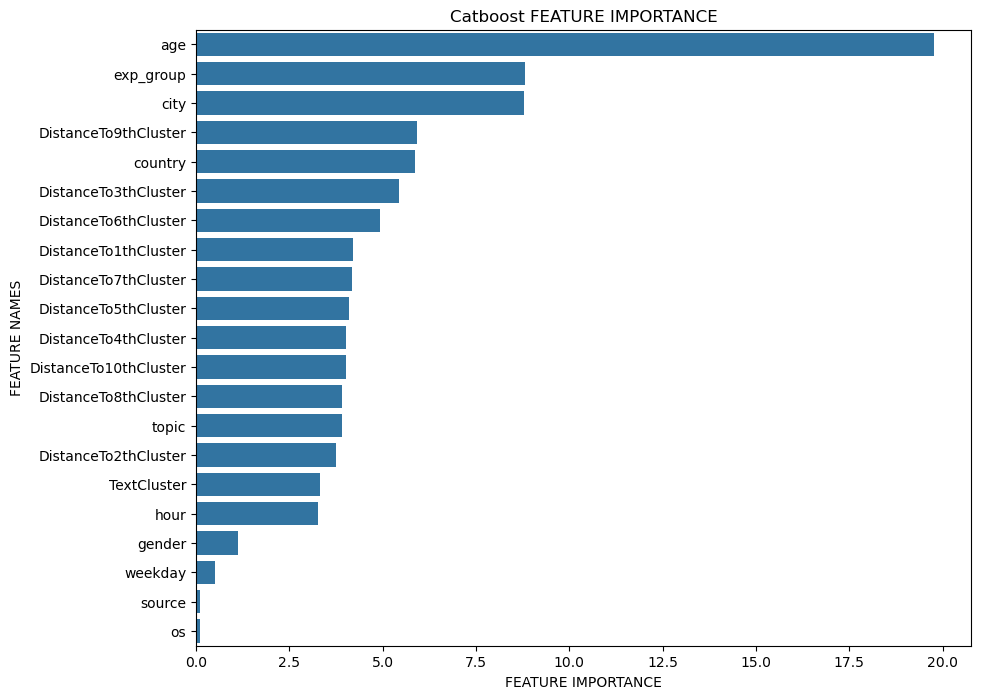

In [53]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_,X_train.columns,'Catboost')

In [106]:
model = CatBoostClassifier(random_state=8, cat_features=cat_feachures, verbose=50, early_stopping_rounds=50, custom_loss='AUC')
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.1, 0.15, 0.2]
}

splitter = ShuffleSplit(n_splits=3)

grid_search = model.grid_search(param_grid=param_grid,
                                X=X_train, y=y_train, cv=splitter, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6197067	test: 0.6192660	best: 0.6192660 (0)	total: 235ms	remaining: 3m 54s
50:	learn: 0.3443244	test: 0.3392335	best: 0.3392335 (50)	total: 7.54s	remaining: 2m 20s
100:	learn: 0.3411493	test: 0.3368896	best: 0.3368896 (100)	total: 15.9s	remaining: 2m 21s
150:	learn: 0.3393908	test: 0.3360720	best: 0.3360720 (150)	total: 24.9s	remaining: 2m 19s
200:	learn: 0.3377912	test: 0.3353557	best: 0.3353517 (199)	total: 33.3s	remaining: 2m 12s
250:	learn: 0.3365797	test: 0.3350880	best: 0.3350880 (250)	total: 41.8s	remaining: 2m 4s
300:	learn: 0.3353763	test: 0.3348716	best: 0.3348634 (296)	total: 50.5s	remaining: 1m 57s
350:	learn: 0.3343930	test: 0.3347194	best: 0.3347194 (350)	total: 59s	remaining: 1m 49s
400:	learn: 0.3335007	test: 0.3346250	best: 0.3346151 (391)	total: 1m 7s	remaining: 1m 40s
450:	learn: 0.3326274	test: 0.3345350	best: 0.3345347 (447)	total: 1m 15s	remaining: 1m 32s
500:	learn: 0.3318063	test: 0.3344597	best: 0.3344576 (498)	total: 1m 24s	remaining: 1m 23s
550:	l

In [74]:
best_params = grid_search['params']
best_params

{'depth': 8, 'l2_leaf_reg': 2}

In [75]:
best_model = CatBoostClassifier(**best_params, random_state=8, early_stopping_rounds=50,
                                custom_loss=['AUC', 'Accuracy'],  cat_features=cat_feachures)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_4_5')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))